In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


/usr/lib64/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = False, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData()

In [3]:
# helper functions

def date2vector(implementdate, start = '22/1/20', end = '31/3/20', shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    endtime       = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))



def LogCaseIncrease(df, key = 'Confirmed', mincases = None):
    cases             = np.array(df[key], dtype = np.int)
    if not mincases is None:
        restrict_date = np.argmin(cases >= mincases)
        cases         = cases[restrict_date:]
    else:
        restrict_date = 0
    ldcases           = np.log(np.diff(cases))

    return restrict_date, ldcases


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])

In [57]:
def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
        trajectories[country] = {}
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 20)
    measureIDs           = GetMeasureIDs(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = [CleanUpMeasureName(mn) for mn in measureIDs.keys()]
    regressionDF         = None
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:
            df_entry_dict               = {}
            df_entry_dict['Country']    = country
            
            # ********************************************
            # change observable to regress here:
            df_entry_dict['Observable'] = np.diff(np.log(trajectories[country]['traj']))
            # ********************************************
            
            if not (np.isnan(df_entry_dict['Observable']).any() or np.isinf(df_entry_dict['Observable']).any()):
                if verbose:
                    # print trajectories of individual countries for checking
                    print(country,df_entry_dict['Observable'])
                obslen                      = len(df_entry_dict['Observable'])
                df_entry_dict['Time']       = np.arange(obslen)

                for measurename in measureIDs.keys():
                    implementdate = measure_data.FindMeasure(country, measurename, measure_level)
                    if not implementdate is None:
                        vec = date2vector(implementdate = implementdate, start = trajectories[country]['startdate'], shiftdays = shiftdays)[:obslen]
                    else:
                        vec = np.zeros(obslen)
                    df_entry_dict[CleanUpMeasureName(measurename)] = vec

                if regressionDF is None:
                    regressionDF = pd.DataFrame(df_entry_dict)
                else:
                    regressionDF = regressionDF.append(pd.DataFrame(df_entry_dict))
    
    return regressionDF, cleaned_measurelist


In [55]:
# regression and store everything
summary_df = []

for shiftdays in np.arange(11):

    # generate all data into pandas DF for regression
    regrDF,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays)

    # model formula
    formula = 'Observable ~ Time + C(Country) + ' + ' + '.join(ml)
    #print(formula + '\n')

    # regression with General Linear Model (GLM)
    model   = smf.glm(formula = formula, data = regrDF)
    results = model.fit()

    # output

    # print(results.summary())
    
    filename = 'regression_shiftdays{}.csv'.format(shiftdays)

    def dropheaderlines(csv_string, droplines = 10):
        return '\n'.join(csv_string.split('\n')[droplines:])

    csv_table = results.summary().as_csv()

    fp = open(filename,'w')
    fp.write(dropheaderlines(csv_table))
    fp.close()

    readdata = pd.read_csv(filename)
    print('shiftdays = {}'.format(shiftdays))
    print(readdata[readdata['P>|z| '] < 0.05].sort_values(by = 'P>|z| ')[['                                               ', '   coef   ','P>|z| ']])
    print()
                           
    summary_df.append(readdata)

shiftdays = 0
                                                        coef     P>|z| 
0   Intercept                                            0.2706   0.000
73  TracingAndMonitoring                                 0.1408   0.000
33  Time                                                -0.0044   0.000
68  SearchForAndorMonitorContacts                       -0.1151   0.002
15  C(Country)[T.Japan]                                 -0.2646   0.002
38  EducateAndActivelyCommunicateWithThePublic          -0.0568   0.002
8   C(Country)[T.Ecuador]                               -0.3189   0.003
56  CrisisManagementPlans                                0.0635   0.003
54  CallForReturnOfNationalsLivingAbroad                -0.0742   0.006
32  C(Country)[T.Thailand]                              -0.1870   0.011
6   C(Country)[T.Denmark]                                0.2124   0.013
19  C(Country)[T.Malaysia]                              -0.1859   0.019
14  C(Country)[T.Italy]                           

shiftdays = 6
                                                        coef     P>|z| 
0   Intercept                                            0.2437   0.000
2   C(Country)[T.Belgium]                                0.3279   0.000
31  C(Country)[T.Switzerland]                            0.3051   0.000
32  C(Country)[T.Thailand]                              -0.1996   0.000
68  SearchForAndorMonitorContacts                       -0.1415   0.000
14  C(Country)[T.Italy]                                  0.1976   0.001
29  C(Country)[T.Spain]                                  0.2228   0.001
66  ResearchAndTestOfContacts                           -0.1220   0.002
52  AirportRestriction                                   0.0688   0.002
19  C(Country)[T.Malaysia]                              -0.1950   0.003
55  CordonSanitairemandatoryQuarantine                  -0.0958   0.003
62  SmallGatheringCancellation                          -0.0529   0.008
79  Surveillance                                  

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


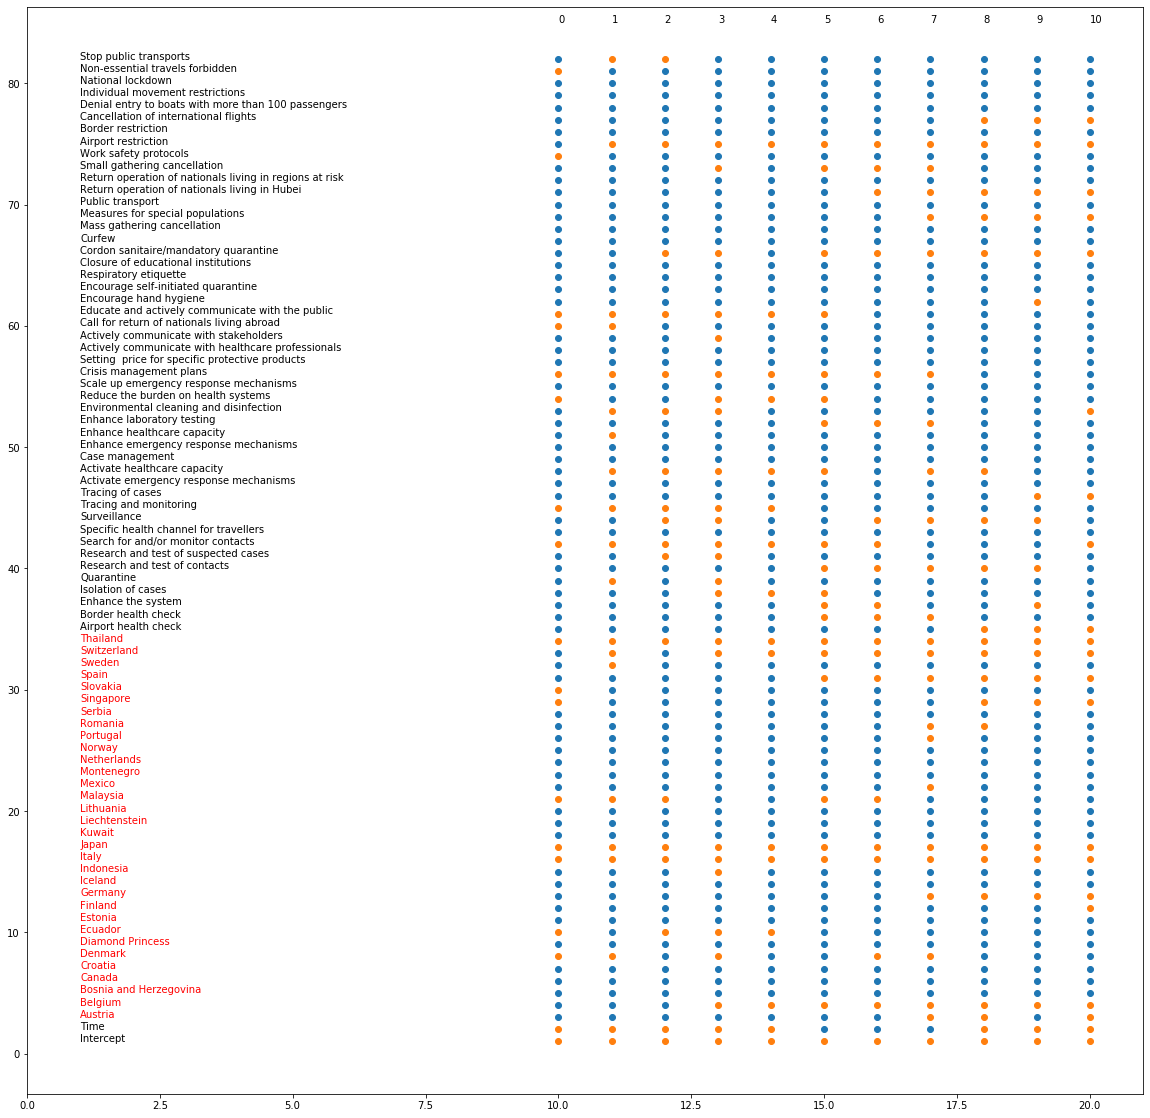

In [89]:
# helper functions
def getPvalue(shiftdays = 0, country = None, key = None, measure = None):
    if not country is None:
        dfkey = '{:47s}'.format('C(Country)[T.' + country + ']')
    elif not key is None:
        dfkey = '{:47s}'.format(key)
    elif not measure is None:
        dfkey = '{:47s}'.format(measure)
    plist = summary_df[shiftdays][summary_df[shiftdays]['{:47s}'.format('')] == dfkey]['P>|z| ']
    return np.float(plist)
            
def p2color(p):
    if p < 0.05:
        return 'TAB:ORANGE'
    else:
        return 'TAB:BLUE'

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

# collect all countries
countrylist = [name[13:].split(']')[0] for name in summary_df[0]['                                               '] if name[:4] == 'C(Co']

fig,ax = plt.subplots(figsize = (20,20))

label_x  = 1
label_dy = 1

plot_x   = 10
plot_dx  =  1


for shiftdays in np.arange(11):
    if shiftdays == 0:
        ax.annotate('Intercept', (label_x, 1 * label_dy), c = 'black')
        ax.annotate('Time',      (label_x, 2 * label_dy), c = 'black')
    
    pval_intercept = getPvalue(shiftdays, key = 'Intercept')
    pval_time      = getPvalue(shiftdays, key = 'Time')
    ax.scatter([plot_x + shiftdays],[1 * label_dy], c = p2color(pval_intercept))
    ax.scatter([plot_x + shiftdays],[2 * label_dy], c = p2color(pval_time))
    i = 3
    for country in countrylist:
        if shiftdays == 0:
            ax.annotate(country, (label_x, i * label_dy), c = 'red')
        
        pval_country = getPvalue(shiftdays, country = country)
        ax.scatter([plot_x + shiftdays],[i * label_dy], c = p2color(pval_country))
        i += 1
    
    l1keys = list(measure_level_dict.keys())
    l1keys.sort()
    
    for l1key in l1keys:
        l2keys = list(measure_level_dict[l1key].keys())
        l2keys.sort()
        for l2key in l2keys:
            if shiftdays == 0:
                ax.annotate(l2key,[label_x, i*label_dy])
            
            pval_measure = getPvalue(shiftdays, measure = measure_level_dict[l1key][l2key])
            ax.scatter([plot_x + shiftdays],[i * label_dy], c = p2color(pval_measure))
            i += 1
    ax.axes.set_xlim([0,21])
    #ax.axes.set_ypim([])
    
    ax.annotate('{}'.format(shiftdays),[plot_x + shiftdays,(i+2)*label_dy])
    
fig.show()
